In [1]:
import os
import gc
import glob
import numpy as np
import pandas as pd
import multiprocessing
import seaborn as sns

from joblib import Parallel, delayed
from sklearn.metrics import pairwise_distances

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font', family='Microsoft JhengHei')

pd.set_option('display.max_columns', None)
print(f"CPU核心數量: {multiprocessing.cpu_count()}")

CPU核心數量: 64


In [2]:
# 請根據你的環境設定資料夾路徑
DATA_DIR = "D:\\Data\\Kline\\UsdFutures"  # 調整為你的資料夾位置

# 假設每個 CSV 名稱格式如 BTCUSDT.csv, ETHUSDT.csv, ...
file_list = glob.glob(os.path.join(DATA_DIR, '*USDT.csv'))
print(f"找到 {len(file_list)} 個 CSV 檔案")

# 移動平均視窗設定（例如5分鐘移動平均降噪）
WINDOW = 15  

# 若資料量超大，可設定 chunk size，例如：1_000_000；否則設定 None 一次讀取
CHUNK_SIZE = None  

# CSV欄位名稱設定 (請依實際檔案內容調整)
TIME_COL = 'OpenTime'
OPEN_COL = 'OpenPrice'
HIGH_COL = 'HighPrice'
LOW_COL = 'LowPrice'
CLOSE_COL = 'ClosePrice'
VOLUME_COL = 'QuoteVolume'

# 計算相關時使用的價格欄位 (這裡以 close 為例)
PRICE_COL = CLOSE_COL
N_top = 150


找到 348 個 CSV 檔案


In [3]:
def process_single_csv(file_path,
                       time_col=TIME_COL,
                       price_col=PRICE_COL,
                       volume_col=VOLUME_COL,
                       window=WINDOW,
                       chunksize=CHUNK_SIZE):
    """
    讀取單個 CSV，計算對數收益並做移動平均降噪。
    返回 DataFrame: [timestamp, symbol, smoothed_log_return]
    """
    # 根據檔名推測交易對 symbol，例如 'BTCUSDT.csv' -> 'BTCUSDT'
    symbol = os.path.splitext(os.path.basename(file_path))[0]

    df_list = []

    if chunksize is None:
        # 一次性讀取
        df_raw = pd.read_csv(file_path)
        # 取需要的欄位
        df_raw = df_raw[[time_col, price_col, volume_col]].dropna()
        # 排序保證時間先後
        df_raw.sort_values(by=time_col, inplace=True)
        # 計算對數收益
        df_raw['log_price'] = np.log(df_raw[price_col])
        df_raw['log_return'] = df_raw['log_price'].diff()
        # 移動平均降噪
        df_raw['smoothed_log_return'] = df_raw['log_return'].rolling(window, min_periods=1).mean()
        # 加上 symbol 欄
        df_raw['symbol'] = symbol

        # 移除第一筆 (diff會產生 NaN) 與其他缺失值
        df_raw.dropna(subset=['smoothed_log_return'], inplace=True)

        result = df_raw[[time_col, 'symbol', 'smoothed_log_return', volume_col]]
        df_list.append(result)

        # 釋放暫存記憶體
        del df_raw
        gc.collect()
    else:
        # 若資料量太大，分 chunk 讀取
        reader = pd.read_csv(file_path, chunksize=chunksize)
        prev_log_price = None

        for chunk in reader:
            chunk = chunk[[time_col, price_col, volume_col]].dropna()
            chunk.sort_values(by=time_col, inplace=True)
            chunk['log_price'] = np.log(chunk[price_col])

            # 若有前一個 chunk 的最後一筆 log_price，計算第一筆的 diff
            if prev_log_price is not None:
                chunk.loc[chunk.index[0], 'log_return'] = chunk.loc[chunk.index[0], 'log_price'] - prev_log_price
            chunk['log_return'] = chunk['log_price'].diff()

            # 移動平均降噪 (此處僅在每個 chunk 內做 rolling)
            chunk['smoothed_log_return'] = chunk['log_return'].rolling(window, min_periods=1).mean()

            # 記錄最後一筆 log_price，供下一個 chunk 使用
            prev_log_price = chunk.loc[chunk.index[-1], 'log_price']

            chunk['symbol'] = symbol
            chunk.dropna(subset=['smoothed_log_return'], inplace=True)
            df_list.append(chunk[[time_col, 'symbol', 'smoothed_log_return', volume_col]])
            
            del chunk
            gc.collect()

    if len(df_list) > 0:
        df_final = pd.concat(df_list, ignore_index=True)
    else:
        df_final = pd.DataFrame(columns=[time_col, 'symbol', 'smoothed_log_return'])
    
    return df_final

In [4]:
# 設定並行執行核心數量 (建議保留1個核心給系統)
n_jobs = multiprocessing.cpu_count() - 4

processed_list = Parallel(n_jobs=n_jobs, verbose=10)(
    delayed(process_single_csv)(file) for file in file_list
)

# 拼接所有市場資料
df_all = pd.concat(processed_list, ignore_index=True)

# 釋放暫存

del file_list
del processed_list
gc.collect()

# 將 timestamp 欄位轉成 datetime，根據你的時間格式調整 unit (例如: 'ms' 或 's')
df_all[TIME_COL] = pd.to_datetime(df_all[TIME_COL], unit='ms', utc=True, errors='coerce')
df_all.dropna(subset=[TIME_COL], inplace=True)

print("處理完成，df_all 行數:", len(df_all))
df_all.head()

[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   8 tasks      | elapsed:    3.9s
[Parallel(n_jobs=60)]: Done  25 tasks      | elapsed:    8.4s
[Parallel(n_jobs=60)]: Done  42 tasks      | elapsed:   12.5s
[Parallel(n_jobs=60)]: Done  61 tasks      | elapsed:   16.7s
[Parallel(n_jobs=60)]: Done  80 tasks      | elapsed:   22.2s
[Parallel(n_jobs=60)]: Done 101 tasks      | elapsed:   26.1s
[Parallel(n_jobs=60)]: Done 122 tasks      | elapsed:   30.8s
[Parallel(n_jobs=60)]: Done 145 tasks      | elapsed:   37.8s
[Parallel(n_jobs=60)]: Done 168 tasks      | elapsed:   43.0s
[Parallel(n_jobs=60)]: Done 193 tasks      | elapsed:   47.9s
[Parallel(n_jobs=60)]: Done 218 tasks      | elapsed:   51.5s
[Parallel(n_jobs=60)]: Done 264 out of 348 | elapsed:   59.1s remaining:   18.7s
[Parallel(n_jobs=60)]: Done 299 out of 348 | elapsed:  1.1min remaining:   10.9s
[Parallel(n_jobs=60)]: Done 334 out of 348 | elapsed:  1.3min remaining:    3.1

處理完成，df_all 行數: 281877438


,OpenTime,symbol,smoothed_log_return,QuoteVolume
0,2022-02-25 00:01:00+00:00,1INCHUSDT,-0.006965,143985.2927
1,2022-02-25 00:02:00+00:00,1INCHUSDT,-0.003821,188617.7024
2,2022-02-25 00:03:00+00:00,1INCHUSDT,-0.002096,27947.5508
3,2022-02-25 00:04:00+00:00,1INCHUSDT,-0.001629,43621.6328
4,2022-02-25 00:05:00+00:00,1INCHUSDT,-0.000868,36284.7832


In [5]:
# 建立字典，每個 symbol 對應一個 DataFrame（包含成交量欄位）
# 2. 以 groupby.apply 計算每個 symbol 的小時成交量平均值
def hourly_avg_volume(group):
    # 設定索引後按小時重取樣求和
    hourly_vol = group.set_index(TIME_COL)[VOLUME_COL].resample('1h').sum()
    return hourly_vol.mean()

avg_volumes = df_all.groupby('symbol').apply(hourly_avg_volume).to_dict()

# 建立成交量排序的 DataFrame
df_vol = pd.DataFrame(list(avg_volumes.items()), columns=['symbol', 'avg_hourly_volume'])
df_vol.sort_values('avg_hourly_volume', ascending=False, inplace=True)
print("成交量排名前 10 的市場：")
display(df_vol.head(10))

# 取前 N_top 的 symbol
top_symbols = df_vol.head(N_top)['symbol'].tolist()
print(f"保留成交量排名前 {N_top} 的市場，共 {len(top_symbols)} 個")

del df_vol, avg_volumes
gc.collect()

成交量排名前 10 的市場：


C:\Users\Kenneth\AppData\Local\Temp\2\ipykernel_17116\2869223253.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_volumes = df_all.groupby('symbol').apply(hourly_avg_volume).to_dict()


,symbol,avg_hourly_volume
66,BTCUSDT,5.924462e+08
114,ETHUSDT,3.122264e+08
303,TRUMPUSDT,1.505319e+08
164,KAITOUSDT,1.063863e+08
272,SOLUSDT,7.805657e+07
334,XRPUSDT,4.254811e+07
97,DOGEUSDT,4.071595e+07
158,IPUSDT,3.510696e+07
234,PNUTUSDT,3.364351e+07
207,NEIROUSDT,3.295067e+07


保留成交量排名前 150 的市場，共 150 個


0

In [6]:
# 轉寬格式：index 為 timestamp，columns 為 symbol，值為 smoothed_log_return
df_list = [
    group[['OpenTime', 'smoothed_log_return']].assign(symbol=symbol)
    for symbol, group in df_all.groupby('symbol')
    if symbol in top_symbols
]

# 合併所有資料
combined_df = pd.concat(df_list)

# Pivot 成寬表格，行為時間、欄位為 symbol 的 smoothed_log_return
df_pivot = combined_df.pivot(index='OpenTime', columns='symbol', values='smoothed_log_return')

del top_symbols, df_all, combined_df

# 依據時間重新索引，確保每分鐘都有資料
date_range = pd.date_range(
    start=df_pivot.index.min().floor('min'),
    end=df_pivot.index.max().ceil('min'),
    freq='1T'  # 每1分鐘
)
df_pivot = df_pivot.reindex(date_range)

print("寬格式資料形狀:", df_pivot.shape)
df_pivot.head()


C:\Users\Kenneth\AppData\Local\Temp\2\ipykernel_17116\1349468008.py:17: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  date_range = pd.date_range(


寬格式資料形狀: (1578240, 150)


symbol,1MBABYDOGEUSDT,AAVEUSDT,ACTUSDT,ADAUSDT,AEVOUSDT,AI16ZUSDT,AIXBTUSDT,ALCHUSDT,ALGOUSDT,ALTUSDT,ANIMEUSDT,APEUSDT,APTUSDT,ARBUSDT,ARCUSDT,ARKMUSDT,ATOMUSDT,AVAXUSDT,AXSUSDT,B3USDT,BANUSDT,BBUSDT,BCHUSDT,BERAUSDT,BIGTIMEUSDT,BIOUSDT,BLURUSDT,BNBUSDT,BOMEUSDT,BTCUSDT,CATIUSDT,CFXUSDT,CGPTUSDT,CHILLGUYUSDT,CHZUSDT,COOKIEUSDT,COWUSDT,CRVUSDT,CYBERUSDT,DOGEUSDT,DOGSUSDT,DOTUSDT,DRIFTUSDT,DYDXUSDT,EIGENUSDT,ENAUSDT,ENSUSDT,EOSUSDT,ETCUSDT,ETHFIUSDT,ETHUSDT,FARTCOINUSDT,FETUSDT,FILUSDT,GALAUSDT,GASUSDT,GMTUSDT,GOATUSDT,GPSUSDT,GRASSUSDT,GRIFFAINUSDT,HBARUSDT,HEIUSDT,HIVEUSDT,HMSTRUSDT,IDUSDT,INJUSDT,IOUSDT,IPUSDT,JASMYUSDT,JTOUSDT,JUPUSDT,KAITOUSDT,LAYERUSDT,LDOUSDT,LINAUSDT,LINKUSDT,LTCUSDT,MANAUSDT,MANTAUSDT,MASKUSDT,MELANIAUSDT,MEMEUSDT,MEUSDT,MEWUSDT,MKRUSDT,MOCAUSDT,MOODENGUSDT,MORPHOUSDT,MOVEUSDT,NEARUSDT,NEIROETHUSDT,NEIROUSDT,NOTUSDT,OMUSDT,ONDOUSDT,OPUSDT,ORDIUSDT,PENDLEUSDT,PENGUUSDT,PEOPLEUSDT,PIXELUSDT,PNUTUSDT,POPCATUSDT,PYTHUSDT,RAREUSDT,RENDERUSDT,RUNEUSDT,SAGAUSDT,SANDUSDT,SEIUSDT,SHELLUSDT,SOLUSDT,SOLVUSDT,SPXUSDT,STRKUSDT,STXUSDT,SUIUSDT,SUNUSDT,SUSDT,SUSHIUSDT,SWARMSUSDT,TAOUSDT,THEUSDT,TIAUSDT,TONUSDT,TRBUSDT,TROYUSDT,TRUMPUSDT,TRXUSDT,TSTUSDT,TURBOUSDT,UNIUSDT,USUALUSDT,UXLINKUSDT,VANAUSDT,VINEUSDT,VIRTUALUSDT,VTHOUSDT,VVVUSDT,WIFUSDT,WLDUSDT,WUSDT,XAIUSDT,XLMUSDT,XRPUSDT,YGGUSDT,ZEREBROUSDT,ZILUSDT,ZROUSDT
2022-02-25 00:01:00+00:00,NaN,-0.006152,NaN,-0.005165,NaN,NaN,NaN,NaN,-0.004128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.004955,-0.005515,-0.009055,NaN,NaN,NaN,-0.005871,NaN,NaN,NaN,NaN,-0.002966,NaN,-0.001425,NaN,NaN,NaN,NaN,-0.004458,NaN,NaN,-0.005805,NaN,-0.006152,NaN,-0.004209,NaN,-0.005976,NaN,NaN,-0.005764,-0.004351,-0.006503,NaN,-0.002628,NaN,NaN,-0.004076,-0.008226,NaN,NaN,NaN,NaN,NaN,NaN,-0.005301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.006554,-0.005211,-0.003460,-0.005452,NaN,-0.004751,NaN,NaN,NaN,NaN,-0.005720,NaN,NaN,NaN,NaN,-0.005426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.010457,NaN,NaN,NaN,NaN,NaN,NaN,-0.005790,NaN,-0.006464,NaN,NaN,-0.004028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.006406,NaN,NaN,NaN,NaN,NaN,-0.005139,NaN,NaN,-0.002955,NaN,NaN,-0.005344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.004175,-0.006041,NaN,NaN,-0.005249,NaN
2022-02-25 00:02:00+00:00,NaN,-0.002596,NaN,-0.003112,NaN,NaN,NaN,NaN,-0.002129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.003185,-0.003021,-0.003908,NaN,NaN,NaN,-0.003689,NaN,NaN,NaN,NaN,-0.001525,NaN,-0.000984,NaN,NaN,NaN,NaN,-0.002413,NaN,NaN,-0.002902,NaN,-0.002346,NaN,-0.001981,NaN,-0.002289,NaN,NaN,-0.002809,-0.002418,-0.002588,NaN,-0.001395,NaN,NaN,-0.001902,-0.003385,NaN,NaN,NaN,NaN,NaN,NaN,-0.002674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002729,-0.002038,-0.001105,-0.002493,NaN,-0.002375,NaN,NaN,NaN,NaN,-0.003657,NaN,NaN,NaN,NaN,-0.003305,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.004083,NaN,NaN,NaN,NaN,NaN,NaN,-0.003476,NaN,-0.001290,NaN,NaN,-0.002912,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.003685,NaN,NaN,NaN,NaN,NaN,-0.002054,NaN,NaN,-0.001478,NaN,NaN,-0.002843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002280,-0.003453,NaN,NaN,-0.003415,NaN
2022-02-25 00:03:00+00:00,NaN,-0.001891,NaN,-0.002075,NaN,NaN,NaN,NaN,-0.001247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002366,-0.002497,-0.003777,NaN,NaN,NaN,-0.001968,NaN,NaN,NaN,NaN,-0.001063,NaN,-0.000644,NaN,NaN,NaN,NaN,-0.001466,NaN,NaN,-0.002084,NaN,-0.001564,NaN,-0.001052,NaN,-0.001061,NaN,NaN,-0.001653,-0.001450,-0.001448,NaN,-0.000975,NaN,NaN,-0.000959,-0.002639,NaN,NaN,NaN,NaN,NaN,NaN,-0.001550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.001637,-0.000905,-0.001250,-0.001895,NaN,-0.001504,NaN,NaN,NaN,NaN,-0.002385,NaN,NaN,NaN,NaN,-0.002440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.001453,NaN,NaN,NaN,NaN,NaN,NaN,-0.002318,NaN,-0.001015,NaN,NaN,-0.002541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.001707,NaN,NaN,NaN,NaN,NaN,-0.001198,NaN,NaN,-0.001040,NaN,NaN,-0.002123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000805,-0.000909,NaN,NaN,-0.001925,NaN
2022-02-25 00:04:00+00:00,NaN,-0.001338,NaN,-0.001527,NaN,NaN,NaN,NaN,-

In [7]:
# 使用皮爾遜相關係數計算市場間相似度 (columns 為 symbol)
cor_matrix = df_pivot.corr(method='pearson')
print("相關矩陣大小:", cor_matrix.shape)
cor_matrix.head()

# 釋放 df_pivot（若後續不再使用）
del df_pivot
gc.collect()

相關矩陣大小: (150, 150)


0

C:\Users\Kenneth\AppData\Local\Temp\2\ipykernel_17116\315605494.py:14: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(dist_matrix, method='average')


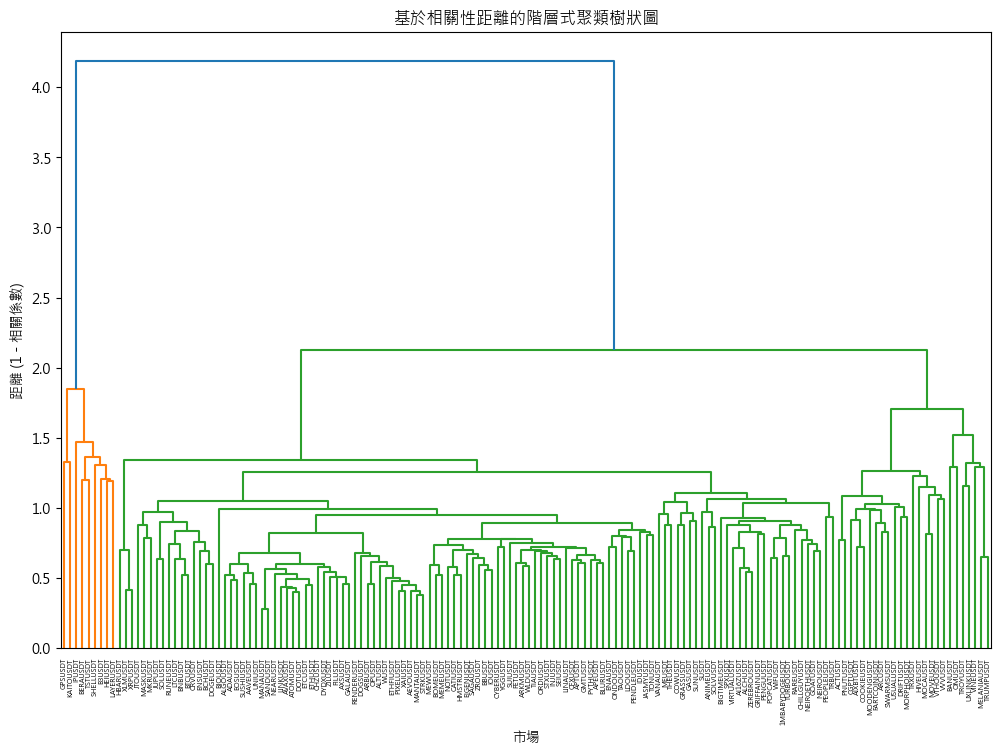

In [8]:
from scipy.cluster.hierarchy import linkage, dendrogram

# 填補 NaN 值 (若某些市場間無足夠重疊，將其視為相關性 0)
cor_matrix_filled = cor_matrix.fillna(0)

# 以相關矩陣建立距離矩陣 (d = 1 - correlation)
dist_matrix = 1 - cor_matrix_filled

# 檢查是否有非有限值
if not np.all(np.isfinite(dist_matrix)):
    raise ValueError("距離矩陣中仍含有非有限值！")

# 使用 average linkage 進行階層式聚類
Z = linkage(dist_matrix, method='average')

# 繪製樹狀圖
plt.figure(figsize=(12, 8))
dendrogram(Z, labels=cor_matrix.columns, leaf_rotation=90)
plt.title("基於相關性距離的階層式聚類樹狀圖")
plt.xlabel("市場")
plt.ylabel("距離 (1 - 相關係數)")
plt.show()

In [9]:
import itertools

# 取得所有市場列表
symbols = cor_matrix.columns.tolist()

# 產生所有不重複的市場對 (i < j)
pairs = []
for i in range(len(symbols)):
    for j in range(i+1, len(symbols)):
        m1 = symbols[i]
        m2 = symbols[j]
        corr_value = cor_matrix.loc[m1, m2]
        pairs.append((m1, m2, corr_value))

# 按相關係數由大到小排序（降冪排序）
pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)

# 根據條件挑選 5 組配對：市場間不能重複出現
selected_pairs = []
used_markets = set()

for pair in pairs_sorted:
    m1, m2, corr_value = pair
    if m1 not in used_markets and m2 not in used_markets:
        selected_pairs.append(pair)
        used_markets.add(m1)
        used_markets.add(m2)
    if len(selected_pairs) == 5:
        break

print("挑選出的 5 組最佳且市場不重複的配對：")
for m1, m2, corr_value in selected_pairs:
    print(f"{m1} <--> {m2} : 相關係數 = {corr_value:.4f}")

# 釋放不再需要的記憶體
del pairs, pairs_sorted
gc.collect()

挑選出的 5 組最佳且市場不重複的配對：
MANAUSDT <--> SANDUSDT : 相關係數 = 0.8940
BTCUSDT <--> ETHUSDT : 相關係數 = 0.8448
JUPUSDT <--> SOLUSDT : 相關係數 = 0.7985
DOGSUSDT <--> NOTUSDT : 相關係數 = 0.7874
ADAUSDT <--> DOTUSDT : 相關係數 = 0.7774


17054

c:\Users\Kenneth\.conda\envs\Quant\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  fig.canvas.draw()
c:\Users\Kenneth\.conda\envs\Quant\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


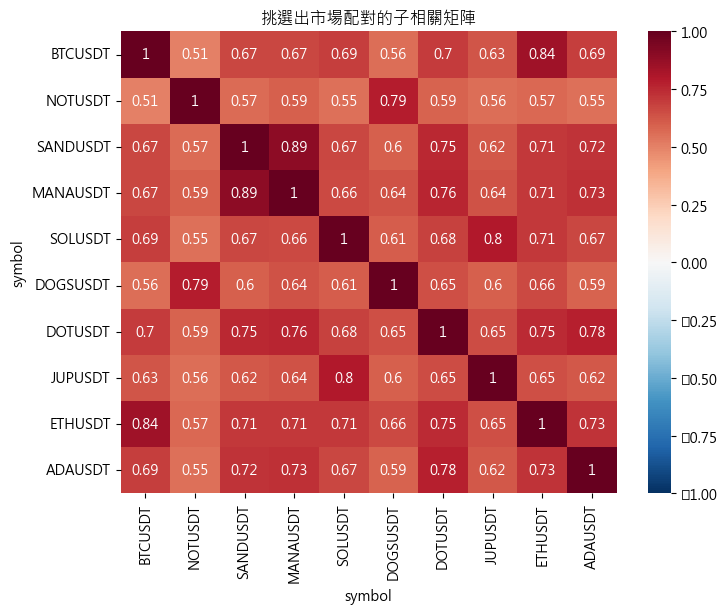

In [10]:
# 將挑選出的市場名稱整理
selected_markets = []
for m1, m2, _ in selected_pairs:
    selected_markets.extend([m1, m2])
selected_markets = list(set(selected_markets))  # 應該有 10 個不同市場

# 從完整相關矩陣中取出這些市場的子矩陣
sub_cor = cor_matrix.loc[selected_markets, selected_markets]

plt.figure(figsize=(8, 6))
sns.heatmap(sub_cor, annot=True, cmap="RdBu_r", vmin=-1, vmax=1)
plt.title('挑選出市場配對的子相關矩陣')
plt.show()